In [1]:
import time
import math
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'

import hoomd
import gsd.hoomd

from pair import lj

In [2]:
seed=9920
device = hoomd.device.CPU()
sim = hoomd.Simulation(device=device, seed=seed) # 5th one can be redo because it's done with seed 5.
mc = hoomd.hpmc.integrate.Sphere(default_d=0.1)
mc.shape["A"] = dict(diameter=1.0)

sigma = 1.0
epsilon = 1.88

lj = lj.format(sigma=sigma, epsilon=epsilon)
patch = hoomd.hpmc.pair.user.CPPPotential(r_cut=3.0*sigma, 
                                          code=lj,
                                          param_array=[])

mc.pair_potential = patch
sim.create_state_from_gsd(filename='./DATA/random.gsd')

In [3]:
logger = hoomd.logging.Logger()
logger.add(mc, quantities=['type_shapes'])

trigger = hoomd.trigger.And([hoomd.trigger.Periodic(100),
                             hoomd.trigger.After(sim.timestep+5000)])
gsd_writer = hoomd.write.GSD(filename='./DATA/unbiased.gsd',
                             trigger=trigger,
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=logger)

/Users/lina492375qw1188/opt/miniconda3/envs/patchy/lib/python3.9/site-packages/hoomd/write/gsd.py:183: FutureWarning: log keyword arguments passed to <hoomd.write.gsd.GSD object at 0x118afefd0> is deprecated since v3.9.0. Use logger instead.
  warnings.warn(


In [4]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(moves=['a', 'd'],
                                             target=0.2,
                                             trigger=hoomd.trigger.And([hoomd.trigger.Periodic(100),
                                                                        hoomd.trigger.Before(sim.timestep+5000)]),
                                             max_translation_move=0.2,
                                             max_rotation_move=0.2)

In [5]:
sim.operations.writers.append(gsd_writer)
sim.operations.integrator = mc
sim.operations.tuners.append(tune)

#### tune

In [6]:
sim.run(5000)

#### equilibriate

In [7]:
start = time.time()

sim.run(1e5)

print('Time elapsed', time.time()-start)

Time elapsed 85.02730202674866


In [8]:
from order_parameters import compute_num_liq as compute_op

In [9]:
traj = gsd.hoomd.open('./DATA/unbiased.gsd', 'rb')

In [10]:
op_arr = []
for frame in traj:
    op = compute_op(frame)
    op_arr.append(op)

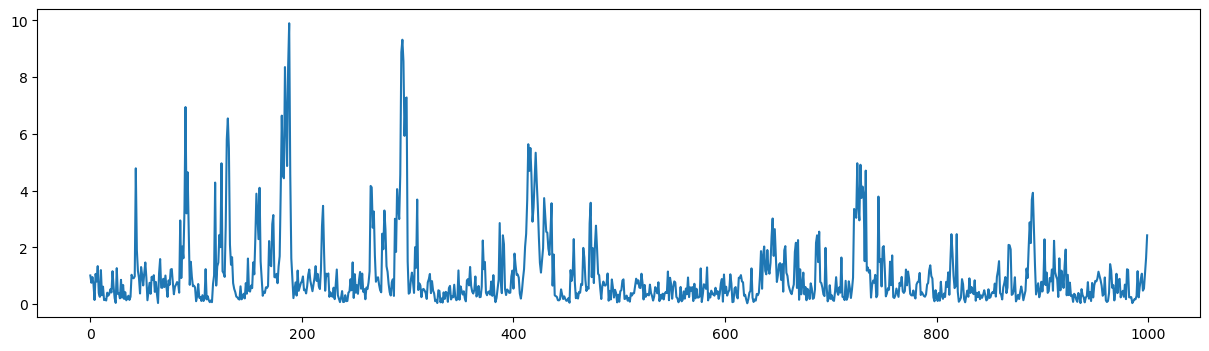

In [11]:
fig = plt.figure(figsize=(15,4))

ax = fig.subplots(nrows=1, ncols=1)

ax.plot(op_arr)

plt.show()